# Regression

In [39]:
### --- Dependencies --- ###
from importlib import reload
import definitions as df
import torch
from tqdm import tqdm
import datetime
import importlib
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import datetime
import os
import solvers
importlib.reload(solvers)

torch.set_default_dtype(torch.float64)

reload(df)


# parser = argparse.ArgumentParser(description='PyTorch NTK Uncertainty Estimate Experiment')
# parser.add_argument('--dataset',default='cifar',type=str,help='dataset (cifar or imagenet)')
# args = parser.parse_args()

### --- CONSTANTS --- ###
dataset_str = 'concrete'
TRAIN_RATIO = 0.9
BATCH_SIZE = 100
NORMALIZE_X = True
NORMALIZE_Y = True
LAYER_WIDTH = 150
NTK_WEIGHT_INIT = True

NTK_MODEL_PATH = "./model_chkpt/ntk_network.pt"
ENSEMBLE_MODEL_PATH = "./model_chkpt/ensemble_networks.pt"

ensemble_M = 5

FIND_MAN_KAPPA = False
REPORT_KAPPA = False
FIND_FUNC_JAX_KAPPA = True
KAPPA_COMPARISON = FIND_MAN_KAPPA and FIND_FUNC_JAX_KAPPA

### --- INPUT DATA HERE AS WELL AS DATASET NAME --- ###
if dataset_str == 'energy':
    data = pd.read_excel('.\data\Energy\ENB2012_data.xlsx')
    num_features = 8
elif dataset_str == 'concrete':
    data = pd.read_excel('.\data\Concrete\Concrete_Data.xls')
    num_features = 8

# print(data.shape)
print("--- Loading dataset {} --- \n".format(dataset_str))
print("Number of data points = {}".format(len(data)))
print("Number of coloumns = {}".format(len(data.columns)))
print("Number of features = {}".format(num_features))

training_set, test_set = df.data_split(data,TRAIN_RATIO)

if NORMALIZE_X:
    train_mX = training_set[:,:num_features].mean(axis=0)
    train_sX = training_set[:,:num_features].std(axis=0)
    train_sX[train_sX==0]=1
else:
    train_mX = 0
    train_sX = 1

if NORMALIZE_Y:
    train_my = training_set[:,num_features].mean(axis=0)
    train_sy = training_set[:,num_features].std(axis=0)
    if train_sy==0:
        train_sy=1
else:
    train_my = 0
    train_sy = 1

train_dataset = df.RegressionDataset(training_set, input_dim=num_features, mX=train_mX, sX=train_sX, my=train_my, sy=train_sy)
test_dataset = df.RegressionDataset(test_set, input_dim=num_features, mX=train_mX, sX=train_sX)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_set), shuffle=False)

np.set_printoptions(suppress=True, precision=4)
print("\n Sample training point \n X: {}, \n y: {} \n".format(train_dataset.__getitem__(0)[0], train_dataset.__getitem__(0)[1]))
print("Sample test point \n X: {}, \n y: {} ".format(test_dataset.__getitem__(0)[0], test_dataset.__getitem__(0)[1]))

--- Loading dataset concrete --- 

Number of data points = 1030
Number of coloumns = 9
Number of features = 8
training set has shape (927, 9) 

test set has shape (103, 9)

 Sample training point 
 X: tensor([-0.5984, -0.2321,  1.0782, -1.9256,  0.9501,  1.3352,  0.2451,  0.1559]), 
 y: 1.5599938380740697 

Sample test point 
 X: tensor([ 0.5547,  1.3161, -0.8466, -0.3139,  0.5469, -0.3646, -0.2156, -0.6113]), 
 y: 35.101223159999996 


In [45]:
from importlib import reload
reload(df)

<module 'definitions' from 'c:\\Users\\s4531973\\Documents\\PhD\\Code\\Uncertainty Quantification\\definitions.py'>

In [47]:
learning_rate = 1e-2
epochs = 4000
train_ensemble = True

## Create Model
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ntk_network = df.MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(df.weights_init)
print("Number of parameters in NTK network = {}".format(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

## Train NTK network
mse_loss = nn.MSELoss(reduction='mean')
ntk_optimizer = df.optimizer_shared(ntk_network, type='adam', learning_rate=learning_rate)
early_stopper = df.EarlyStopper(patience=50,min_delta=5)
# ntk_scheduler = optim.lr_scheduler.StepLR(ntk_optimizer,epochs/4,gamma=0.1)
# ntk_plateau_sched = optim.lr_scheduler.ReduceLROnPlateau(ntk_optimizer,'min',factor=0.5)
# ntk_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     ntk_optimizer,
#     int(epochs/8),
#     eta_min=1e-4
# )

# Run the training loop
print("\n Training NTK network \n")
for epoch in tqdm(range(epochs)):
    ntk_train_mse  = df.training_loop_ntk(
        dataloader=train_loader,
        model=ntk_network, 
        optimizer=ntk_optimizer,
        loss_function=mse_loss,
        verbose=False)
    
    ntk_test_mse, ntk_test_rel_error = df.test_loop_ntk(
        dataloader=test_loader,
        model = ntk_network,
        my=train_my,
        sy=train_sy,
        loss_function=mse_loss)
    
    # ntk_plateau_sched.step(ntk_test_mse)
    # ntk_scheduler.step()

    if early_stopper.early_stop(ntk_test_mse):
        break

    if epoch % int(epochs/4) == 0:
        print("Epoch {} of {}".format(epoch,epochs))
        print("Training MSE = {:.3f}".format(ntk_train_mse))
        print("Test MSE = {:.2f}".format(ntk_test_mse))
        # print("Learning rate = {}".format(ntk_scheduler.get_last_lr()))
    
# Process is complete.
print('\n NTK Training process has finished.')
print("Final training MSE = {:.3f}".format(ntk_train_mse))
print("Final test MSE = {:.2f}".format(ntk_test_mse))
print("Final epoch = {}".format(epoch))

torch.save({
    'model': ntk_network.state_dict(),
    'train_mse': ntk_train_mse,
    'test_mse': ntk_test_mse,
    'test_rel_err': ntk_test_rel_error
    },
    NTK_MODEL_PATH)

# ## 

# ensemble_model_list = []
# ensemble_model_state_list = []
# ensemble_opt_list = []
# ensemble_sched_list = []
# ensemble_mse_training_list = np.empty(ensemble_M)
# ensemble_mse_test_list = np.empty(ensemble_M)
# ensemble_nll_list = np.empty(ensemble_M)
# ensemble_rel_err_test_list = np.empty((ensemble_M,len(test_dataset)))

# NLL = df.CustomNLL()
# for i in range(ensemble_M):
#     ensemble_model_list.append(df.EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
#     ensemble_opt_list.append(df.optimizer_shared(ensemble_model_list[i], type='adam', learning_rate=learning_rate))
#     ensemble_sched_list.append(optim.lr_scheduler.StepLR(ensemble_opt_list[i],epochs/4,gamma=0.5))

# for i in range(ensemble_M):
#     print(f"\n Training ensemble {i+1} ")
#     for epoch in tqdm(range(epochs)):
#         ensemble_train_mse = df.training_loop_ensemble(
#             dataloader=train_loader, 
#             model=ensemble_model_list[i], 
#             optimizer=ensemble_opt_list[i], 
#             loss_function=NLL,
#             mse_loss= mse_loss,
#             verbose=False)
        
#         ensemble_test_mse, ensemble_test_nll, ensemble_test_rel_err = df.test_loop_ensemble(
#             dataloader=test_loader, 
#             model=ensemble_model_list[i], 
#             my=train_my, 
#             sy=train_sy, 
#             mse_loss=mse_loss,
#             loss_function=NLL)
        
#         ensemble_sched_list[i].step()
        
#         if epoch % (epochs/4) == 0:
#             print("Epoch {} of {}".format(epoch,epochs))
#             print("Training MSE = {:.3f}".format(ensemble_train_mse))
#             print("Test MSE = {:.2f}".format(ensemble_test_mse))
#             print("Learning rate = {}".format(ensemble_sched_list[i].get_last_lr()))

#     print("Done!")
#     ensemble_mse_training_list[i] = ensemble_train_mse
#     ensemble_mse_test_list[i] = ensemble_test_mse
#     ensemble_nll_list[i] = ensemble_test_nll
#     ensemble_rel_err_test_list[i,:] = ensemble_test_rel_err.detach().numpy().squeeze(1)
# print('\n Ensemble training process has finished.')

# ## Print training metrics
# print("Final ntk training MSE = {:.4f}".format(ntk_train_mse))
# print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
# print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
# print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

# for i in range(ensemble_M):
#     ensemble_model_state_list.append(ensemble_model_list[i].state_dict())

# torch.save({
#     'models': ensemble_model_state_list,
#     'train_mse': ensemble_mse_training_list,
#     'test_mse': ensemble_mse_test_list,
#     'test_nll': ensemble_nll_list,
#     'test_rel_err': ensemble_rel_err_test_list
#     },
#     ENSEMBLE_MODEL_PATH)

# print("Model saved!")

Using cpu device
Number of parameters in NTK network = 92101

 Training NTK network 



  0%|          | 3/4000 [00:00<02:54, 22.93it/s]

Epoch 0 of 4000
Training MSE = 0.887
Test MSE = 127.46


 25%|██▌       | 1003/4000 [00:44<02:59, 16.65it/s]

Epoch 1000 of 4000
Training MSE = 0.009
Test MSE = 16.28


 25%|██▌       | 1017/4000 [00:45<02:14, 22.17it/s]


 NTK Training process has finished.
Final training MSE = 0.012
Final test MSE = 16.42
Final epoch = 1017


Using cpu device
Loading models:
Models loaded.
torch.Size([927, 1, 150, 8])

 --- Finding uncertainty estimates --- 

Norm of residual array (y-f) = 2.782936708628986
Norm of resid_solve = 24796.404919970508


  1%|          | 1/103 [00:00<00:20,  5.08it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  2%|▏         | 2/103 [00:00<00:18,  5.45it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  3%|▎         | 3/103 [00:00<00:21,  4.66it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  5%|▍         | 5/103 [00:01<00:20,  4.70it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  6%|▌         | 6/103 [00:01<00:20,  4.84it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  7%|▋         | 7/103 [00:01<00:18,  5.12it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  8%|▊         | 8/103 [00:01<00:22,  4.29it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


  9%|▊         | 9/103 [00:01<00:21,  4.36it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 11%|█         | 11/103 [00:02<00:19,  4.71it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 12%|█▏        | 12/103 [00:02<00:18,  4.90it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 13%|█▎        | 13/103 [00:02<00:18,  4.90it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 14%|█▎        | 14/103 [00:02<00:17,  5.11it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 16%|█▌        | 16/103 [00:03<00:17,  5.10it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 17%|█▋        | 17/103 [00:03<00:16,  5.09it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 17%|█▋        | 18/103 [00:03<00:18,  4.63it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 19%|█▉        | 20/103 [00:04<00:17,  4.85it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 20%|██        | 21/103 [00:04<00:16,  4.98it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 21%|██▏       | 22/103 [00:04<00:16,  5.04it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 22%|██▏       | 23/103 [00:04<00:15,  5.11it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 23%|██▎       | 24/103 [00:04<00:15,  4.94it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 25%|██▌       | 26/103 [00:05<00:15,  4.89it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 27%|██▋       | 28/103 [00:05<00:15,  4.86it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 28%|██▊       | 29/103 [00:05<00:14,  5.08it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 30%|███       | 31/103 [00:06<00:14,  5.04it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 32%|███▏      | 33/103 [00:06<00:13,  5.22it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 33%|███▎      | 34/103 [00:06<00:13,  5.28it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 34%|███▍      | 35/103 [00:07<00:16,  4.13it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 36%|███▌      | 37/103 [00:07<00:14,  4.54it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 38%|███▊      | 39/103 [00:08<00:13,  4.86it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 39%|███▉      | 40/103 [00:08<00:12,  5.00it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 41%|████      | 42/103 [00:08<00:12,  5.04it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 42%|████▏     | 43/103 [00:08<00:12,  4.76it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 44%|████▎     | 45/103 [00:09<00:13,  4.22it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 45%|████▍     | 46/103 [00:09<00:12,  4.44it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 46%|████▌     | 47/103 [00:09<00:11,  4.75it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 48%|████▊     | 49/103 [00:10<00:10,  5.19it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 50%|████▉     | 51/103 [00:10<00:10,  5.05it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 50%|█████     | 52/103 [00:10<00:09,  5.24it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 52%|█████▏    | 54/103 [00:11<00:09,  5.30it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 53%|█████▎    | 55/103 [00:11<00:08,  5.43it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 55%|█████▌    | 57/103 [00:11<00:08,  5.30it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 56%|█████▋    | 58/103 [00:11<00:08,  5.37it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 57%|█████▋    | 59/103 [00:12<00:08,  5.37it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 58%|█████▊    | 60/103 [00:12<00:08,  5.34it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 59%|█████▉    | 61/103 [00:12<00:07,  5.27it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 60%|██████    | 62/103 [00:12<00:07,  5.15it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 62%|██████▏   | 64/103 [00:13<00:07,  4.94it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 63%|██████▎   | 65/103 [00:13<00:08,  4.71it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 65%|██████▌   | 67/103 [00:13<00:08,  4.39it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 66%|██████▌   | 68/103 [00:14<00:07,  4.75it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 68%|██████▊   | 70/103 [00:14<00:06,  5.06it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 69%|██████▉   | 71/103 [00:14<00:06,  5.10it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 70%|██████▉   | 72/103 [00:14<00:05,  5.25it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 71%|███████   | 73/103 [00:14<00:05,  5.29it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 73%|███████▎  | 75/103 [00:15<00:05,  5.12it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 74%|███████▍  | 76/103 [00:15<00:05,  5.27it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 75%|███████▍  | 77/103 [00:15<00:04,  5.44it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 77%|███████▋  | 79/103 [00:16<00:04,  5.17it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 79%|███████▊  | 81/103 [00:16<00:03,  5.53it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 81%|████████  | 83/103 [00:16<00:03,  5.40it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 82%|████████▏ | 84/103 [00:17<00:03,  5.30it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 83%|████████▎ | 85/103 [00:17<00:03,  5.19it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 83%|████████▎ | 86/103 [00:17<00:03,  5.34it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 84%|████████▍ | 87/103 [00:17<00:02,  5.37it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 86%|████████▋ | 89/103 [00:18<00:03,  4.53it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 87%|████████▋ | 90/103 [00:18<00:02,  4.75it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 88%|████████▊ | 91/103 [00:18<00:02,  4.73it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 89%|████████▉ | 92/103 [00:18<00:02,  4.21it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 90%|█████████ | 93/103 [00:19<00:02,  4.25it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 92%|█████████▏| 95/103 [00:19<00:01,  4.35it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 93%|█████████▎| 96/103 [00:19<00:01,  4.66it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 94%|█████████▍| 97/103 [00:19<00:01,  5.01it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 95%|█████████▌| 98/103 [00:20<00:01,  4.95it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 97%|█████████▋| 100/103 [00:20<00:00,  4.73it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 98%|█████████▊| 101/103 [00:20<00:00,  5.00it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


 99%|█████████▉| 102/103 [00:20<00:00,  5.22it/s]

torch.Size([1, 1, 150, 8])
torch.Size([1, 1, 150, 8])


100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


Finished! 

Number of zero values uncertainty array: 0
Number of negative values for full rank: 0

 --- Plotting Results --- 



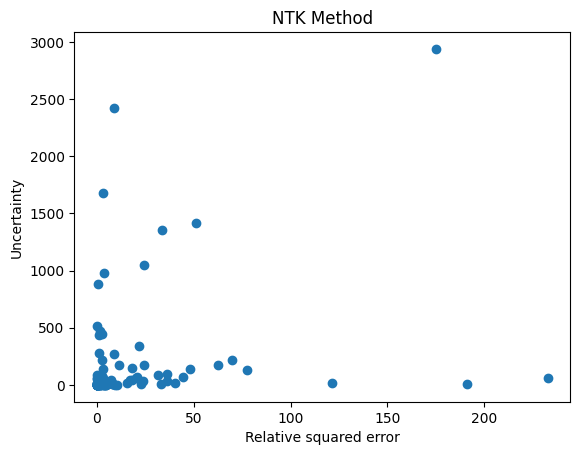

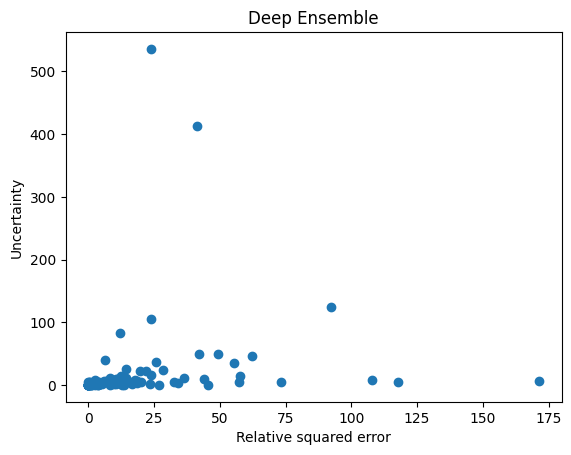

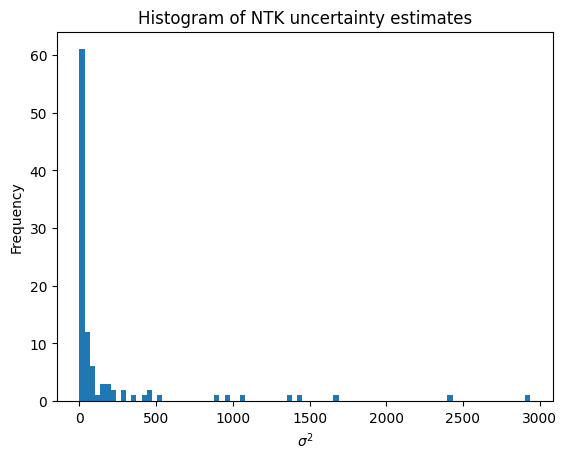

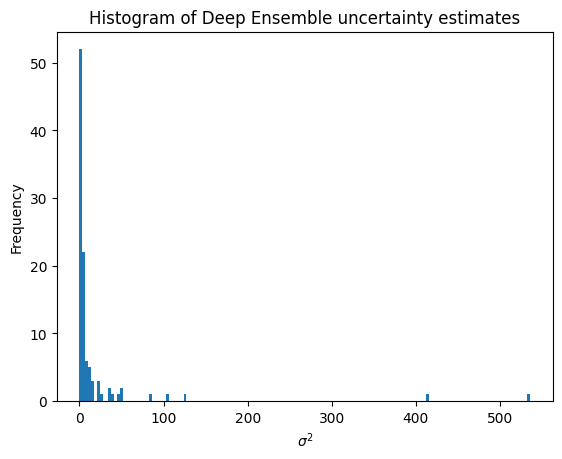

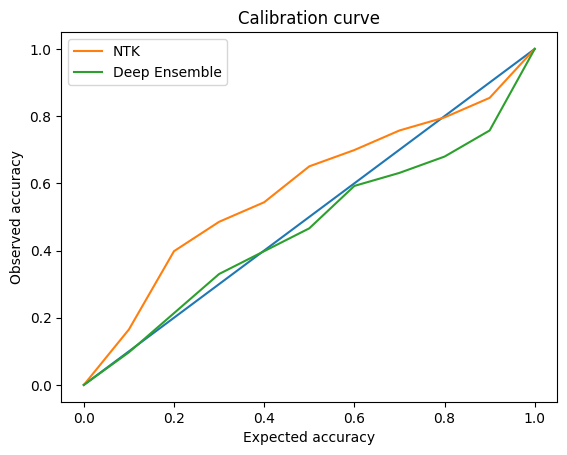

Final ntk training MSE = 0.012
Final ntk test MSE = 16.42
Final ensemble training MSE = [0.0188 0.0157 0.0177 0.0115 0.036 ]
Final ensemble test MSE = [13.3967 17.075  19.8286 14.9882 20.5739]


In [79]:
type_solve = 'iterative'
rtol_solve = 1e-9
maxit_solve = 2000

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## load models
print("Loading models:")

# Load NTK Model
ntk_saved_model = torch.load(NTK_MODEL_PATH)

ntk_network = df.MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(df.weights_init)
ntk_network.load_state_dict(ntk_saved_model['model'])
ntk_network.eval()

ntk_train_mse = ntk_saved_model['train_mse']
ntk_test_mse = ntk_saved_model['test_mse']
ntk_test_rel_error = ntk_saved_model['test_rel_err']

# Load Ensemble Models
ensemble_saved_models = torch.load(ENSEMBLE_MODEL_PATH)

ensemble_model_list = []
for i in range(ensemble_M):
    ensemble_model_list.append(df.EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_model_list[i].load_state_dict(ensemble_saved_models['models'][i])
    ensemble_model_list[i].eval()

ensemble_mse_training_list = ensemble_saved_models['train_mse']
ensemble_mse_test_list = ensemble_saved_models['test_mse']
ensemble_nll_list = ensemble_saved_models['test_nll']
ensemble_rel_err_test_list = ensemble_saved_models['test_rel_err']

print("Models loaded.")

### --- NTK --- ###
if FIND_MAN_KAPPA:
    EPSILON = 0
    print("\n --- Finding Kappa --- \n")
    kappa_man_time_start = time.time()
    Kappa_man = df.ntk_matrix(train_dataset,train_dataset,model=ntk_network,optimizer=ntk_optimizer)
    kappa_man_time_end = time.time()
    kappa_man_time = kappa_man_time_end - kappa_man_time_start
    eigvals = np.linalg.eigvalsh(Kappa_man)

if FIND_FUNC_JAX_KAPPA:
    kappa_jax_time_start = time.time()
    Kappa = df.empirical_ntk(
        model=ntk_network,
        dataset1=train_dataset,
        dataset2=train_dataset
    )
    Kappa_jax = Kappa.detach().numpy().squeeze((2,3))
    kappa_jax_time_end = time.time()
    kappa_jax_time = kappa_jax_time_end - kappa_jax_time_start
    eigvals = np.linalg.eigvalsh(Kappa_jax)

if REPORT_KAPPA:
    print("\n--- Kappa (Manual) Summary --- \n")
    print("Condition number of Kappa = {:.2f}".format(np.linalg.cond(Kappa)))
    eigvals = np.linalg.eigvalsh(Kappa)
    print("Number of negative eigenvalues of Kappa = {}".format(eigvals[eigvals<0].size))
    print("Number of zero eigenvalues of Kappa = {}".format(eigvals[eigvals==0].size))
    print("Smallest eigenvalue is = {}".format(sorted(eigvals)[0]))

if KAPPA_COMPARISON:

    man_eigvals = np.linalg.eigvalsh(Kappa_man)
    jax_eigvals = np.linalg.eigvalsh(Kappa_jax)

    plot_dir = "./ntk_conditioning_results/"
    results_name = "results.txt"
    with open(plot_dir+results_name,'w') as results:
        results.write("{} \n".format(datetime.datetime.now()))
        results.write("Manual method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {}, \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_man_time,
                                                     np.linalg.cond(Kappa_man),
                                                        man_eigvals[man_eigvals<0].size,
                                                        sorted(man_eigvals)[0])
        )
        results.write("\n PyTorch JAX method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {} \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_jax_time,
                                                     np.linalg.cond(Kappa_jax),
                                                        jax_eigvals[jax_eigvals<0].size,
                                                        sorted(jax_eigvals)[0])
        )
        results.write("Frobenius norm difference between two methods = {}".format(
            np.linalg.norm(Kappa_man-Kappa_jax)
        ))

### --- Current Kappa --- ###
        
Kappa = Kappa_jax

## Uncertainty Quantification
print("\n --- Finding uncertainty estimates --- \n")
uncert_time_start = time.time()
uncertainty_array, solver_info, uncertainty_array_lifted, mu = df.ntk_uncertainty_explicit(
    Kappa=Kappa, 
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=ntk_network,
    type=type_solve,
    rtol=rtol_solve,
    maxit=maxit_solve)
uncert_time_end = time.time()
uncert_time = uncert_time_end-uncert_time_start # (seconds)
solver_info_mean = np.mean(solver_info,axis=1)
print("Finished! \n")
print("Number of zero values uncertainty array: {}".format(uncertainty_array[uncertainty_array==0].size))
print("Number of negative values for full rank: {}".format(uncertainty_array[uncertainty_array<0].size))

# uncertainty_array = uncertainty_array / np.sqrt(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad))

mu_mean, sigma_mean = df.ensemble_result(
    test_loader=test_loader,
    ensemble_M=ensemble_M,
    model_list=ensemble_model_list,
    sy=train_sy,
    my=train_my
)
ensemble_rel_err_test_list = np.mean(ensemble_rel_err_test_list,axis=0)

### --- Plot results --- ###
param_ntk = sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)

print("\n --- Plotting Results --- \n")
today = datetime.date.today()
now = datetime.datetime.now()
# plot_dir = "./data/{}/{}/plot/".format(dataset_str, today.strftime("%d_%m_%Y"))
# plot_dir = "./data/{}/{}/plot/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
plot_dir = "./data/{}/early_stop_p_2_{}/plot/".format(dataset_str,param_ntk)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

## NTK Scatter
plot_name = "ntk_scatter.pdf"
plt.scatter(ntk_test_rel_error, uncertainty_array*(train_sy**2))
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("NTK Method")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

# ## NTK Lifted Scatter
# plot_name = "ntk_lifted_scatter.pdf"
# plt.scatter(ntk_test_rel_error, uncertainty_array_lifted*(train_sy**2))
# plt.xlabel("Relative squared error")
# plt.ylabel("Uncertainty")
# plt.title("NTK Lifted Method")
# plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
# plt.show()

## Deep Ensemble scatter
plot_name = "ensemble_scatter.pdf"
plt.scatter(ensemble_rel_err_test_list, sigma_mean)
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("Deep Ensemble")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## NTK Histogram
plot_name = "ntk_hist.pdf"
plt.hist(sorted((train_sy**2)*uncertainty_array.squeeze(0)), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of NTK uncertainty estimates")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

# ## NTK Lifted Histogram
# plot_name = "ntk_lifted_hist.pdf"
# plt.hist(sorted((train_sy**2)*uncertainty_array_lifted.squeeze(0)), bins='auto')
# plt.xlabel("$\sigma^2$")
# plt.ylabel("Frequency")
# plt.title("Histogram of NTK Lifted uncertainty estimates")
# plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
# plt.show()

## Deep Ensemble Histogram
plot_name = "ensemble_hist.pdf"
plt.hist(sorted(sigma_mean), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of Deep Ensemble uncertainty estimates")
plt.savefig(plot_dir + plot_name.format(dataset_str), format="pdf", bbox_inches="tight")
plt.show()

### --- Plot calibration curve --- ###

plot_name = "calibration_curve.pdf"
observed_true_ntk = df.calibration_curve_ntk(
    testloader=test_loader, 
    uncertainties=uncertainty_array, 
    model=ntk_network, 
    num_c=11, 
    my=train_my, 
    sy=train_sy)
observed_true_ensemble = df.calibration_curve_ensemble(
    testloader=test_loader, 
    mu=mu_mean, 
    sigma2=sigma_mean, 
    num_c=11)
df.plot_calibration(
    observed_true_ntk=observed_true_ntk, 
    observed_true_ensemble=observed_true_ensemble, 
    dataset_str=dataset_str, 
    dir_name=plot_dir, 
    plot_name=plot_name)

# ### --- Plot calibration curve (lifted) --- ###

# plot_name = "calibration_curve_lifted.pdf"
# observed_true_ntk = df.calibration_curve_ntk(
#     testloader=test_loader, 
#     uncertainties=uncertainty_array_lifted, 
#     model=ntk_network, 
#     num_c=11, 
#     my=train_my, 
#     sy=train_sy)
# observed_true_ensemble = df.calibration_curve_ensemble(
#     testloader=test_loader, 
#     mu=mu_mean, 
#     sigma2=sigma_mean, 
#     num_c=11)
# df.plot_calibration(
#     observed_true_ntk=observed_true_ntk, 
#     observed_true_ensemble=observed_true_ensemble, 
#     dataset_str=dataset_str, 
#     dir_name=plot_dir, 
#     plot_name=plot_name)

# result_dir = "./data/{}/{}/result/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
result_dir = "./data/{}/early_stop_p_2_{}/result/".format(dataset_str,param_ntk)
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)

print("Final ntk training MSE = {:.3f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

results_name = "results.txt"
with open(result_dir+results_name,'w') as results:
    results.write("--- Dataset & Model --- \n")
    results.write("Number of training points = {} \n".format(len(training_set)))
    results.write("Number of test points = {} \n".format(len(test_set)))
    results.write("Number of features = {} \n".format(num_features))
    results.write("Number of hidden layers = {} \n".format(3))
    results.write("Width of hidden layer = {} \n".format(LAYER_WIDTH))
    results.write("Number of parameters in NTK network = {} \n".format(
        sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

    results.write("\n --- Results --- \n")
    results.write("Final ntk training mse = {:.3f} \n".format(ntk_train_mse))
    results.write("Final ntk test mse = {:.2f} \n".format(ntk_test_mse))
    results.write("Deep Ensemble training mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_training_list),np.std(ensemble_mse_training_list)))
    results.write("Deep Ensemble test mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_test_list),np.std(ensemble_mse_test_list)))
    results.write("Deep Ensemble NLL: mean = {:.2f}, std {:.2f} \n".format(np.mean(ensemble_nll_list),np.std(ensemble_nll_list)))
    results.write("\n --- Training Details --- \n")
    results.write("Learning Rate = {} \n".format(learning_rate))
    results.write("Training Epochs = {} \n".format(epochs))
    results.write("Number of ensembles = {} \n".format(ensemble_M))

    results.write("\n --- NTK Method Details --- \n")
    results.write("Condition number of Kappa = {:.2f} \n".format(np.linalg.cond(Kappa)))
    results.write("Number of negative eigenvalues of Kappa = {} \n".format(eigvals[eigvals<0].size))
    results.write("Number of zero eigenvalues of Kappa = {} \n".format(eigvals[eigvals==0].size))

    results.write("\n --- Uncertainty Solution Details --- \n")
    results.write("Type of linear solver = {} \n".format(type_solve))
    if type_solve=='iterative':
        results.write("Time to solve all test examples = {:.2f} seconds \n".format(uncert_time))
        results.write("Tolerance of solver = {} \n".format(rtol_solve))
        results.write("Max iteration of solver = {} \n".format(maxit_solve))
        results.write("Average solver iter = {} \n".format(solver_info_mean[0]))
        results.write("Average solver resid error = {} \n".format(solver_info_mean[1]))
        results.write("Average solver matrix resid error = {} \n".format(solver_info_mean[2]))
    results.write("\n Number of negative values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array<0].size))
    results.write("Number of zero values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array==0].size))


In [49]:
test_dataloader = DataLoader(test_dataset,len(test_dataset))
X_test,y_test = next(iter(test_dataloader))
x_hat = ntk_network(X_test)

In [50]:
mu_t = torch.from_numpy(mu).reshape(-1,1)
x_hat = x_hat
y_test = y_test.reshape(-1,1)
print("Sizes are {},{},{}".format(mu_t.shape,x_hat.shape,y_test.shape))
mse_loss = nn.MSELoss(reduction='mean')
print(mse_loss(x_hat*train_sy+train_my,y_test))
print(mse_loss(mu_t*train_sy+train_my,y_test))
print(torch.norm(mu_t-x_hat))
# print(mu_t*train_sy+train_my)
# print(x_hat*train_sy+train_my)


Sizes are torch.Size([103, 1]),torch.Size([103, 1]),torch.Size([103, 1])
tensor(16.4237, grad_fn=<MseLossBackward0>)
tensor(551.8833)
tensor(14.1972, grad_fn=<LinalgVectorNormBackward0>)


# Classification

In [63]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from tqdm import tqdm
import definitions as df
from importlib import reload
import definitions as df
import torch
from tqdm import tqdm
import importlib
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import solvers
importlib.reload(solvers)

torch.set_default_dtype(torch.float64)

reload(df)

N_TRAIN = 1000
N_TEST = 100
N_OUTPUT = 10
learning_rate = 1e-1
batch_size = 50
epochs = 50

training_data = datasets.MNIST(
    root="data/MNIST",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data = torch.utils.data.Subset(training_data,range(N_TRAIN))
test_data = torch.utils.data.Subset(test_data,range(N_TEST))
 
cnn = df.CNN()
print("Number of parameters p = {}".format(sum(p.numel() for p in cnn.parameters() if p.requires_grad)))

train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, N_TEST)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):
    cnn_train_ce = df.train_loop(train_dataloader, cnn, loss_fn, optimizer)
    cnn_test_ce, cnn_test_acc = df.test_loop(test_dataloader, cnn, loss_fn)
    if epoch % int(epochs/50) == 0:
        print("Epoch {} of {}".format(epoch,epochs))
        print("Training CE = {:.3f}".format(cnn_train_ce))
        print("Test CE = {:.2f}".format(cnn_test_ce))
        print("Test accuracy = {:.1f}%".format(100*cnn_test_acc))
print("Done!")
print("Final cnn training cross-entropy = {:.3f}".format(cnn_train_ce))
print("Final cnn test cross-entropy = {:.2f}".format(cnn_test_ce))
print("Final cnn test accuracy = {:.1f}%".format(100*cnn_test_acc))

Number of parameters p = 1301


  2%|▏         | 1/50 [00:00<00:07,  6.14it/s]

Epoch 0 of 50
Training CE = 2.210
Test CE = 1.90
Test accuracy = 39.0%


  4%|▍         | 2/50 [00:00<00:07,  6.20it/s]

Epoch 1 of 50
Training CE = 1.487
Test CE = 1.25
Test accuracy = 55.0%


  6%|▌         | 3/50 [00:00<00:08,  5.77it/s]

Epoch 2 of 50
Training CE = 0.945
Test CE = 1.04
Test accuracy = 65.0%


  8%|▊         | 4/50 [00:00<00:07,  5.94it/s]

Epoch 3 of 50
Training CE = 0.747
Test CE = 0.89
Test accuracy = 69.0%


 10%|█         | 5/50 [00:00<00:07,  5.96it/s]

Epoch 4 of 50
Training CE = 0.635
Test CE = 0.81
Test accuracy = 73.0%


 12%|█▏        | 6/50 [00:00<00:07,  6.13it/s]

Epoch 5 of 50
Training CE = 0.551
Test CE = 0.73
Test accuracy = 77.0%


 14%|█▍        | 7/50 [00:01<00:07,  5.97it/s]

Epoch 6 of 50
Training CE = 0.488
Test CE = 0.67
Test accuracy = 79.0%


 16%|█▌        | 8/50 [00:01<00:06,  6.01it/s]

Epoch 7 of 50
Training CE = 0.440
Test CE = 0.62
Test accuracy = 84.0%


 18%|█▊        | 9/50 [00:01<00:06,  6.05it/s]

Epoch 8 of 50
Training CE = 0.399
Test CE = 0.57
Test accuracy = 85.0%


 20%|██        | 10/50 [00:01<00:06,  6.04it/s]

Epoch 9 of 50
Training CE = 0.367
Test CE = 0.53
Test accuracy = 86.0%


 22%|██▏       | 11/50 [00:01<00:06,  6.01it/s]

Epoch 10 of 50
Training CE = 0.337
Test CE = 0.50
Test accuracy = 87.0%


 24%|██▍       | 12/50 [00:01<00:06,  6.06it/s]

Epoch 11 of 50
Training CE = 0.316
Test CE = 0.49
Test accuracy = 89.0%


 26%|██▌       | 13/50 [00:02<00:06,  5.82it/s]

Epoch 12 of 50
Training CE = 0.297
Test CE = 0.47
Test accuracy = 88.0%


 28%|██▊       | 14/50 [00:02<00:06,  5.91it/s]

Epoch 13 of 50
Training CE = 0.278
Test CE = 0.46
Test accuracy = 88.0%


 30%|███       | 15/50 [00:02<00:05,  5.99it/s]

Epoch 14 of 50
Training CE = 0.266
Test CE = 0.45
Test accuracy = 88.0%


 32%|███▏      | 16/50 [00:02<00:05,  6.05it/s]

Epoch 15 of 50
Training CE = 0.253
Test CE = 0.43
Test accuracy = 88.0%


 34%|███▍      | 17/50 [00:02<00:05,  6.06it/s]

Epoch 16 of 50
Training CE = 0.242
Test CE = 0.42
Test accuracy = 89.0%


 36%|███▌      | 18/50 [00:02<00:05,  6.11it/s]

Epoch 17 of 50
Training CE = 0.231
Test CE = 0.41
Test accuracy = 89.0%


 38%|███▊      | 19/50 [00:03<00:05,  6.09it/s]

Epoch 18 of 50
Training CE = 0.221
Test CE = 0.41
Test accuracy = 89.0%


 40%|████      | 20/50 [00:03<00:04,  6.13it/s]

Epoch 19 of 50
Training CE = 0.212
Test CE = 0.41
Test accuracy = 89.0%


 42%|████▏     | 21/50 [00:03<00:04,  6.14it/s]

Epoch 20 of 50
Training CE = 0.205
Test CE = 0.39
Test accuracy = 89.0%


 44%|████▍     | 22/50 [00:03<00:04,  6.20it/s]

Epoch 21 of 50
Training CE = 0.196
Test CE = 0.39
Test accuracy = 89.0%


 46%|████▌     | 23/50 [00:03<00:04,  6.04it/s]

Epoch 22 of 50
Training CE = 0.188
Test CE = 0.39
Test accuracy = 89.0%


 48%|████▊     | 24/50 [00:03<00:04,  6.02it/s]

Epoch 23 of 50
Training CE = 0.181
Test CE = 0.39
Test accuracy = 89.0%


 50%|█████     | 25/50 [00:04<00:04,  6.09it/s]

Epoch 24 of 50
Training CE = 0.173
Test CE = 0.39
Test accuracy = 89.0%


 52%|█████▏    | 26/50 [00:04<00:03,  6.15it/s]

Epoch 25 of 50
Training CE = 0.168
Test CE = 0.39
Test accuracy = 89.0%


 54%|█████▍    | 27/50 [00:04<00:03,  6.20it/s]

Epoch 26 of 50
Training CE = 0.162
Test CE = 0.38
Test accuracy = 89.0%


 56%|█████▌    | 28/50 [00:04<00:03,  6.13it/s]

Epoch 27 of 50
Training CE = 0.157
Test CE = 0.39
Test accuracy = 89.0%


 58%|█████▊    | 29/50 [00:04<00:03,  6.19it/s]

Epoch 28 of 50
Training CE = 0.151
Test CE = 0.39
Test accuracy = 88.0%


 60%|██████    | 30/50 [00:04<00:03,  6.24it/s]

Epoch 29 of 50
Training CE = 0.146
Test CE = 0.39
Test accuracy = 88.0%


 62%|██████▏   | 31/50 [00:05<00:03,  6.23it/s]

Epoch 30 of 50
Training CE = 0.143
Test CE = 0.38
Test accuracy = 89.0%


 64%|██████▍   | 32/50 [00:05<00:02,  6.24it/s]

Epoch 31 of 50
Training CE = 0.139
Test CE = 0.39
Test accuracy = 88.0%


 66%|██████▌   | 33/50 [00:05<00:02,  6.04it/s]

Epoch 32 of 50
Training CE = 0.135
Test CE = 0.39
Test accuracy = 88.0%


 68%|██████▊   | 34/50 [00:05<00:02,  6.11it/s]

Epoch 33 of 50
Training CE = 0.132
Test CE = 0.39
Test accuracy = 89.0%


 70%|███████   | 35/50 [00:05<00:02,  6.17it/s]

Epoch 34 of 50
Training CE = 0.129
Test CE = 0.40
Test accuracy = 89.0%


 72%|███████▏  | 36/50 [00:05<00:02,  6.21it/s]

Epoch 35 of 50
Training CE = 0.125
Test CE = 0.41
Test accuracy = 88.0%


 74%|███████▍  | 37/50 [00:06<00:02,  6.21it/s]

Epoch 36 of 50
Training CE = 0.121
Test CE = 0.41
Test accuracy = 88.0%


 76%|███████▌  | 38/50 [00:06<00:01,  6.23it/s]

Epoch 37 of 50
Training CE = 0.117
Test CE = 0.43
Test accuracy = 88.0%


 78%|███████▊  | 39/50 [00:06<00:01,  6.22it/s]

Epoch 38 of 50
Training CE = 0.113
Test CE = 0.43
Test accuracy = 88.0%


 80%|████████  | 40/50 [00:06<00:01,  6.23it/s]

Epoch 39 of 50
Training CE = 0.109
Test CE = 0.44
Test accuracy = 87.0%


 82%|████████▏ | 41/50 [00:06<00:01,  6.24it/s]

Epoch 40 of 50
Training CE = 0.106
Test CE = 0.44
Test accuracy = 87.0%


 84%|████████▍ | 42/50 [00:06<00:01,  6.39it/s]

Epoch 41 of 50
Training CE = 0.103
Test CE = 0.44
Test accuracy = 87.0%


 86%|████████▌ | 43/50 [00:07<00:01,  5.98it/s]

Epoch 42 of 50
Training CE = 0.099
Test CE = 0.45
Test accuracy = 87.0%


 88%|████████▊ | 44/50 [00:07<00:00,  6.07it/s]

Epoch 43 of 50
Training CE = 0.097
Test CE = 0.46
Test accuracy = 88.0%


 90%|█████████ | 45/50 [00:07<00:00,  6.12it/s]

Epoch 44 of 50
Training CE = 0.094
Test CE = 0.46
Test accuracy = 88.0%


 92%|█████████▏| 46/50 [00:07<00:00,  6.17it/s]

Epoch 45 of 50
Training CE = 0.090
Test CE = 0.47
Test accuracy = 88.0%


 94%|█████████▍| 47/50 [00:07<00:00,  6.21it/s]

Epoch 46 of 50
Training CE = 0.088
Test CE = 0.47
Test accuracy = 89.0%


 96%|█████████▌| 48/50 [00:07<00:00,  6.19it/s]

Epoch 47 of 50
Training CE = 0.085
Test CE = 0.48
Test accuracy = 88.0%


 98%|█████████▊| 49/50 [00:08<00:00,  6.22it/s]

Epoch 48 of 50
Training CE = 0.080
Test CE = 0.48
Test accuracy = 89.0%


100%|██████████| 50/50 [00:08<00:00,  6.11it/s]

Epoch 49 of 50
Training CE = 0.076
Test CE = 0.49
Test accuracy = 90.0%
Done!
Final cnn training cross-entropy = 0.076
Final cnn test cross-entropy = 0.49
Final cnn test accuracy = 90.0%


In [90]:
from functorch import make_functional
reload(df)

fnet, params = make_functional(cnn)     

def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)[1].reshape(1)

dataset1_ntk = DataLoader(training_data,len(training_data))
x1_ntk,_ = next(iter(dataset1_ntk))
dataset1_single = DataLoader(training_data,1)
x1_single,_ = next(iter(dataset1_single))
dataset2_ntk = DataLoader(training_data,len(training_data))
x2_ntk,_ = next(iter(dataset2_ntk))
test_dataloader = DataLoader(test_data,len(test_data))
x1_test,_ = next(iter(test_dataloader))

# print("Test shape is {}".format(x1_test.shape))
for x1_single in x1_ntk:
    y = fnet_single(params,x1_single)
print("fnet shape is {}".format(y.shape))
print("fnet is {}".format(y))

# # Kappa_c = df.empirical_ntk_jacobian_contraction_c(fnet_single, params, x1_ntk, x2_ntk,c=1)
Kappa = df.empirical_ntk_jacobian_contraction(fnet_single, params, x1_ntk, x2_ntk)
# # kappa_xx = df.empirical_ntk_jacobian_contraction_c(fnet_single=fnet_single,params=params,x1=x1_test,x2=x1_test,c=0)
# # kappa_xX_c = df.empirical_ntk_jacobian_contraction_c(fnet_single=fnet_single,params=params,x1=x1_test,x2=x2_ntk,c=0)
kappa_xX = df.empirical_ntk_jacobian_contraction(fnet_single=fnet_single,params=params,x1=x1_test,x2=x2_ntk)
print(Kappa.shape)
print(kappa_xX.shape)
# # print(kappa_xx.shape)
# # print(kappa_xX.shape)

fnet shape is torch.Size([1])
fnet is tensor([0.2641], grad_fn=<ReshapeAliasBackward0>)
torch.Size([1000, 1000, 1, 1])
torch.Size([100, 1000, 1, 1])


In [16]:
print(torch.norm(kappa_xX[:,:,0,0]-kappa_xX_c))

tensor(6.7744e-12, grad_fn=<LinalgVectorNormBackward0>)


In [91]:
reload(df)

rtol_solve = 1e-5
maxit_solve = 50

uncertainty_array = df.ntk_uncertainty_explicit_class(
    train_dataset=training_data,
    test_dataset=test_data,
    model=cnn,
    num_classes=10,
    type='iterative',
    rtol=rtol_solve,
    maxit=maxit_solve)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 a

In [92]:
print(uncertainty_array)

[[17.5364 21.0882  8.5065 27.0647 13.0698  6.7741 17.8175 16.6966 13.3384
  14.2626 16.2242 20.9794 19.8212 20.361  13.8388 18.1488 18.5528 12.4587
  20.8341 21.8695 20.1175 13.7494 20.5486 21.2474 18.0822 18.6385 15.503
  20.1546 18.7424 13.3568 13.5085 10.1312 14.3332 20.1518 15.181  18.9523
  13.2352 12.4273 12.4975 14.6802  8.3043 14.1669 25.1221 20.8049 17.6817
  20.6766 14.2526 13.4096 20.5259 20.257  16.8495 20.0535 18.8015 12.9767
  22.2016 24.0933 15.445   9.4543 14.4651 10.175  11.1715 16.9677 21.1329
  15.807  14.17   20.7167 24.1153 18.1452 21.4276  8.0959 12.8657 11.4046
  18.0998 14.0939 10.2362 13.35   18.9486  9.6754 14.1036 17.1497 23.2877
  22.7203 15.47   18.0807 18.0083 16.1923 12.8778 25.3248 16.7416  8.2236
  14.2243 15.1983 14.8312 13.2522 14.7048 19.54   14.0704 16.79   11.7886
  16.1118]
 [18.3309 32.4752 16.8345 17.199  20.0927 11.9831 28.2905 22.1094 13.1746
  25.5888 14.6627 49.0078 21.2536 15.2601 14.8782 14.4178 29.0706 10.2974
  24.2303 27.5341 23.4492 14

In [100]:
test_dataloader = DataLoader(test_data,len(test_data))
X_test,_ = next(iter(test_dataloader))
mean = cnn(X_test).detach().numpy().transpose()
n = uncertainty_array[uncertainty_array<0].size
print("Number of negative sigma^2 values = {}".format(n))
print("Mean shape is {}".format(mean.shape))
print("Uncertainty shape is {}".format(uncertainty_array.shape))
probit_approx = df.general_probit_approx(mean,uncertainty_array)
print(mean[:,0])
print(probit_approx[:,0])
print(uncertainty_array[:,0])

Number of negative sigma^2 values = 0
Mean shape is (10, 100)
Uncertainty shape is (10, 100)
[ -6.8565  -3.2292   3.9202  13.766    2.6104  -2.3877 -23.5324  27.3945
  -8.4903  12.918 ]
[-2.4415 -1.1278  1.3402  4.5813  0.9059 -0.8756 -8.4851  9.8461 -3.2231
  4.8712]
[17.5364 18.3309 19.2417 20.4453 18.5985 16.3921 17.0401 17.166  15.1238
 15.3619]
-3.2230785503406523


In [18]:
dataset = DataLoader(training_data,len(training_data))
x,y = next(iter(dataset))
print(x.shape)
print(y.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [ ]:
ood_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)
ood_test_point = ood_data.__getitem__(1)
ood_uncertainty_array=ntk_uncertainty_classification_single(training_data,ood_test_point[0],model=cnn,optimizer=optimizer,num_c=10,mode='max')
test_point = test_data.__getitem__(1)[0]
uncertainty_array=ntk_uncertainty_classification_single(training_data,test_point,model=cnn,optimizer=optimizer,num_c=10,mode='max')
print(uncertainty_array)
print(ood_uncertainty_array)
print(torch.argmax(cnn(ood_test_point[0])).item())
print(ood_test_point[1])

In [4]:
x = torch.ones((4,4,4,4))
print(x[:,:,1,1].shape)

torch.Size([4, 4])
